In [1]:
import numpy
import matplotlib.pyplot as pyplot
import OBE_Tools as OBE
import time

# Examples

This notebook gives some basic examples of using functions in the `OBE_Tools` module to model atomic systems. Often in experiments we are measuring the transmission (or absorption) of the laser coupling the lowest two energy levels ($|1\rangle$ and $|2\rangle$), often referred to as the probe laser.

Each example is set up to be standalone, i.e. cells can be run in any order to generate the outputs. 

# Steady-State Examples

## 3-Level Systems

### Example 1: Addition of a second field
Below is a simple example of using the code to look at the probe absorption as a function of probe detuning ($\Delta_{12}$) in a 3-level system. We look at two cases: where the second laser coupling levels $|2\rangle$ and $|3\rangle$ is turned off ($\Omega_{23} = 0$) and where $\Omega_{23}> \Omega_{12}$.

First we specify lists of parameters ($\Omega, \Delta, \Gamma$ etc.) of the system we want to model. Since here we are changing the probe detuning ($\Delta_{12}$), we create a symmetric array of probe detunings to iterate over. 
For every value in this array, we update the first element in the list of detunings to pass to the function to find the steady state solution. Then we extract the parameter of interest (in this case the probe coherence, $\rho_{12}$ at index 1) and store in an array. 

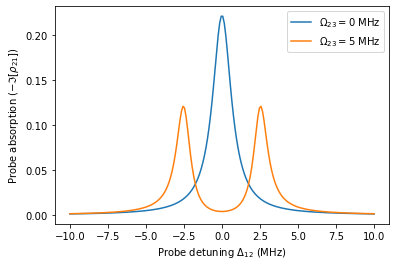

In [2]:
Omegas = [1,5] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [0.5,0.1] #2pi MHz

# Create symmetric array of values for probe detuning (\Delta_{12})
Delta_12 = numpy.linspace(-10,10,200) #2pi MHz
probe_abs = numpy.zeros((2, len(Delta_12))) #Create blank array to store solution

for i, p in enumerate(Delta_12):
    Deltas[0] = p # update value of \Delta_{12}
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas)
    probe_abs[0,i] = numpy.imag(solution[1])
    # repeat but with the second field 'turned off' (\Omega_{23} = 0)
    solution = OBE.steady_state_soln([1,0], Deltas, Gammas)
    probe_abs[1,i] = numpy.imag(solution[1])
    
pyplot.figure()
pyplot.plot(Delta_12, probe_abs[1,:], label = r'$\Omega_{23} = 0$ MHz')
pyplot.plot(Delta_12, probe_abs[0,:], label = r'$\Omega_{23} = 5$ MHz')
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.legend(loc = 0)
pyplot.show()

As expected we see a Lorentzian in the case without the second laser ($\Omega_{23}=0$), and Autler-Townes splitting when the second strong coupling laser is applied ($\Omega_{23}=5$).

### Example 2: Adding dephasing

In the above example we neglected dephasing due to finite laser linewidths, which amounts to assuming that all $\gamma_{ij} = 0$. We can add in this dephasing by specifying values for $\gamma_{ij}$, and see the difference it makes. Note that these parameters are not chosen to be representative of any real system, it is purely to illustrate the effect.

To do this we do exactly the same as previously, but we also create a list of values of $\gamma$ and pass this to the `steady_state_soln` function.

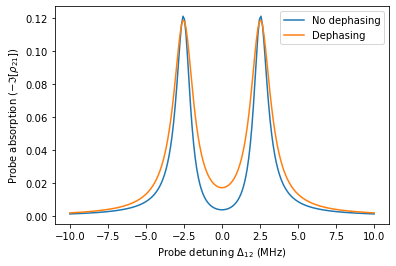

In [3]:
Omegas = [1,5] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [0.5,0.1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-10,10,200) #2pi MHz
probe_abs = numpy.zeros((2, len(Delta_12))) 

for i, p in enumerate(Delta_12):
    Deltas[0] = p
    # first do calculation without dephasing (without passing gammas)
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas)
    probe_abs[0,i] = numpy.imag(solution[1])
    # repeat calculation but this time pass list of gammas
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas)
    probe_abs[1,i] = numpy.imag(solution[1])
    
pyplot.figure()
pyplot.plot(Delta_12, probe_abs[0,:], label = 'No dephasing')
pyplot.plot(Delta_12, probe_abs[1,:], label = 'Dephasing')
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.legend(loc = 0)
pyplot.show()

We can see that the effect of dephasing is to broaden the peaks in the absorption.

### Example 3: State populations

Using the full matrix solution, it is possible to extract all of the parameters of the density matrix. For example if we wanted to look at the populations of the states we just need to extract the relevant terms from the output. For an $n$-level system the value of $\rho_{ii}$ will be located at index $i(n+1)$ for each level $i$. So for our 3-level system, the indices will be `0` ($\rho_{11}$), `4` ($\rho_{22}$) and `8` ($\rho_{33}$).

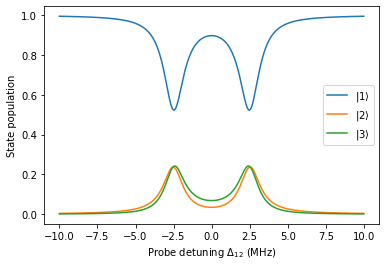

In [4]:
Omegas = [1,5] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [0.5,0.1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-10,10,200) #2pi MHz
pops = numpy.zeros((3, len(Delta_12)))

for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas)
    pops[0,i] = numpy.real(solution[0])
    pops[1,i] = numpy.real(solution[4])
    pops[2,i] = numpy.real(solution[8])
    
pyplot.figure()
for i in range(3):
    pyplot.plot(Delta_12, pops[i,:], label = r'$|{}\rangle$'.format(i+1))
pyplot.legend(loc=0)
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel('State population')
pyplot.show()

### Example 4: Changing $\Delta_{23}$

We can also look at the effect of scanning the laser coupling levels $|2\rangle$ and $|3\rangle$ ($\Delta_{23}$), often called the coupling laser. This is done in the same way as before, but when we loop over all values of $\Delta_{23}$ we need to make sure we address the correct index in the `Deltas` list. We are still looking at the effect on the absorption of the probe laser so are still extracting the value of the probe coherence.

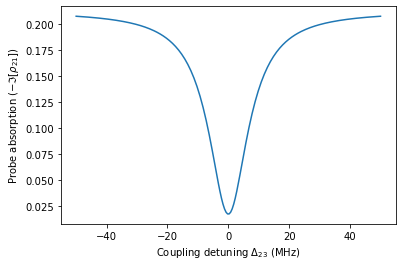

In [5]:
Omegas = [1,5] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [0.5,0.1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_23 = numpy.linspace(-50,50,200) #2pi MHz
probe_abs = numpy.zeros((len(Delta_23)))

for i, c in enumerate(Delta_23):
    Deltas[1] = c
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas)
    probe_abs[i] = numpy.imag(solution[1])
    
pyplot.figure()
pyplot.plot(Delta_23, probe_abs)
pyplot.xlabel('Coupling detuning $\Delta_{23}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.show()

### Example 5: Comparing solution methods (weak-probe)

When using the full matrix solution method, we are solving an eigenvalue problem for every parameter step. This means that this method is NOT fast. However it does allow us to compute results for parameters outside of the weak-probe regime. If the system is in the weak-probe regime, there are analytic solutions for the steady state. For 3-level systems the explicit analytic weak-probe solution can be accessed via the `fast_3_level` function. More details can be found in Section 3.2 of the paper. 


We can compare the results and speed of the two methods. First we set up a system where the weak-probe condition ($\Omega_{12}^2/\Gamma_3(\Gamma_2 + \Gamma_3)\ll 1$) is satisfied. 

Time to complete (matrix method): 5.44 s
Time to complete (analytic method): 0.97 ms


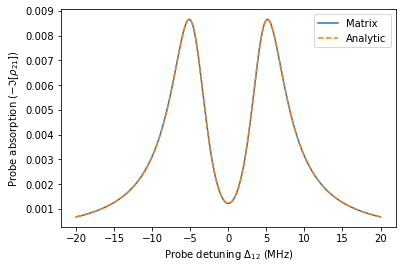

In [6]:
Omegas = [0.1,10] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [10,1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-20,20,200) #2pi MHz
analytic_abs = numpy.zeros((len(Delta_12)))
matrix_abs = numpy.zeros((len(Delta_12)))

# First, using the matrix SVD method via the steady_state_soln function
start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = numpy.imag(solution[1])
    matrix_abs[i] = probe_abs
end = time.time()
print('Time to complete (matrix method): {:.2f} s'.format(end-start))

# Now using the explicit analytic solution via the fast_3_level function
start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_3_level(Omegas, Deltas, Gammas, gammas)
    probe_abs = -numpy.imag(solution)
    analytic_abs[i] = probe_abs
end = time.time()
print('Time to complete (analytic method): {:.2f} ms'.format((end-start)*1000))

pyplot.figure()
pyplot.plot(Delta_12, matrix_abs, label = 'Matrix')
pyplot.plot(Delta_12, analytic_abs, label = 'Analytic', ls = 'dashed')
pyplot.legend()
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.show()

In this case, the weak probe approximation is valid (since  $\Omega_{12}^2/\Gamma_3(\Gamma_2 + \Gamma_3) = 1/21 \ll 1$) and so the two methods give equal results. However the analytic solution is many orders of magnitude faster! 

### Example 6: Comparing solution methods (outside weak-probe)

However, if we don't satisfy the weak probe condition, the difference in results becomes apparent. We keep all parameters the same as in the above example but increase the value of $\Omega_{12}$.

Time to complete (matrix method): 5.38 s
Time to complete (analytic method): 1.02 ms


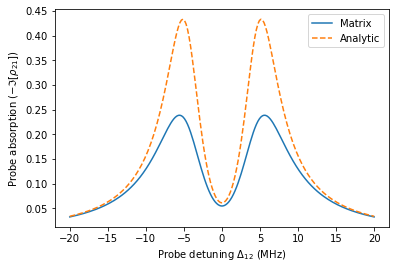

In [7]:
Omegas = [5,10] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [10,1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-20,20,200) #2pi MHz
analytic_abs = numpy.zeros((len(Delta_12)))
matrix_abs = numpy.zeros((len(Delta_12)))

start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = numpy.imag(solution[1])
    matrix_abs[i] = probe_abs
end = time.time()
print('Time to complete (matrix method): {:.2f} s'.format(end-start))
    
start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_3_level(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = -numpy.imag(solution)
    analytic_abs[i] = probe_abs
end = time.time()
print('Time to complete (analytic method): {:.2f} ms'.format((end-start)*1000))

pyplot.figure()
pyplot.plot(Delta_12, matrix_abs, label = 'Matrix')
pyplot.plot(Delta_12, analytic_abs, label = 'Analytic', ls = 'dashed')
pyplot.legend()
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.show()

The weak probe condition is no longer satisfied (since  $\Omega_{12}^2/\Gamma_3(\Gamma_2 + \Gamma_3) = 2.3 > 1$) and so the results of the analytic solution no longer match the full matrix solution.

### Example 7: Comparing all methods (weak-probe)

It is possible to formulate an expression for the analytic solution in the weak probe regime for a ladder scheme with any number of levels. This has to be done iteratively. This has been encapsulated into the function `fast_n_level` which takes the same sets of parameters as the `steady_state_soln` matrix method and returns the value of $\rho_{21}$.

Time to complete (matrix method): 5.56 s
Time to complete (analytic method): 1.00 ms
Time to complete (iterative method): 5.98 ms


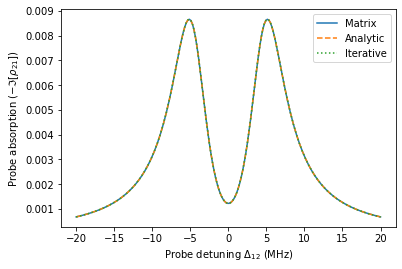

In [8]:
Omegas = [0.1,10] #2pi MHz
Deltas = [0,0] #2pi MHz
Gammas = [10,1] #2pi MHz
gammas = [0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-20,20,200) #2pi MHz
analytic_abs = numpy.zeros((len(Delta_12)))
matrix_abs = numpy.zeros((len(Delta_12)))
iterative_abs = numpy.zeros((len(Delta_12)))

start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = numpy.imag(solution[1])
    matrix_abs[i] = probe_abs
end = time.time()
print('Time to complete (matrix method): {:.2f} s'.format(end-start))
    
start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_3_level(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = -numpy.imag(solution)
    analytic_abs[i] = probe_abs
end = time.time()
print('Time to complete (analytic method): {:.2f} ms'.format((end-start)*1000))

start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_n_level(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = -numpy.imag(solution)
    iterative_abs[i] = probe_abs
end = time.time()
print('Time to complete (iterative method): {:.2f} ms'.format((end-start)*1000))

pyplot.figure()
pyplot.plot(Delta_12, matrix_abs, label = 'Matrix')
pyplot.plot(Delta_12, analytic_abs, label = 'Analytic', ls = 'dashed')
pyplot.plot(Delta_12, iterative_abs, label = 'Iterative', ls = 'dotted')
pyplot.legend()
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.show()

As before in the weak probe regime, the analytic (and the iteratively defined) solution are equal to the full matrix solution. While the iterative method os not as fast as the single analytic expression (as it has to loop through creating the expression for each value of the input parameters) it is still many orders of magnitude faster than the matrix solution!

## 4-Level Systems

Now we can look at a 4-level scheme with 3 laser fields. The methods are all exactly the same as in the 3-level examples, except all our lists of parameters have an extra value (since there are 3 fields instead of 2). The values for parameters must always be in order from lowest to highest energy, for example $[\Omega_{12}, \Omega_{23}, \Omega_{34}]$ or $[\Gamma_2, \Gamma_3, \Gamma_4]$.

### Example 8: Adding a third field

First we will do something similar to Example 1, and look at the change in the probe absorption as we add in a third field. We are still varying the detuning of the probe laser ($\Delta_{12}$) so again we will loop over an array of values for this and update our parameters each time.

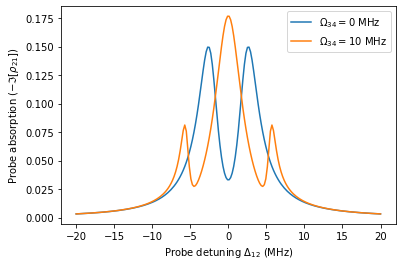

In [9]:
Omegas = [1,5,10] #2pi MHz
Deltas = [0,0,0] #2pi MHz
Gammas = [5,1,0.5] #2pi MHz

Delta_12 = numpy.linspace(-20,20,200) #2pi MHz
probe_abs = numpy.zeros((2, len(Delta_12)))

for i, p in enumerate(Delta_12):
    Deltas[0] = p # update value of \Delta_{12}
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas)
    probe_abs[0,i] = numpy.imag(solution[1])
    # repeat but with the third field 'turned off' (\Omega_{34} = 0)
    solution = OBE.steady_state_soln([Omegas[0], Omegas[1], 0], Deltas, Gammas)
    probe_abs[1,i] = numpy.imag(solution[1])
    
pyplot.figure()
pyplot.plot(Delta_12, probe_abs[1,:], label = r'$\Omega_{34} = 0$ MHz')
pyplot.plot(Delta_12, probe_abs[0,:], label = r'$\Omega_{34} = 10$ MHz')
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.legend(loc = 0)
pyplot.show()

### Example 9: Comparing solution methods

Again, similar to Examples 6 and 7, we can compare the results and the time taken for the three different solution methods (SVD, explicit analytic solution and iterative analytic solution).

Time to complete (matrix method): 10.84 s
Time to complete (analytic method): 1.00 ms
Time to complete (iterative method): 9.94 ms


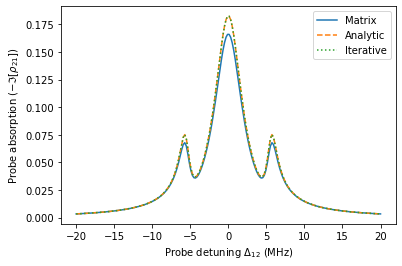

In [10]:
Omegas = [1,5,10] #2pi MHz
Deltas = [0,0,0] #2pi MHz
Gammas = [5,1,0.5] #2pi MHz
gammas = [0.1,0.1,0.1] #2pi MHz

Delta_12 = numpy.linspace(-20,20,200) #2pi MHz
analytic_abs = numpy.zeros((len(Delta_12)))
matrix_abs = numpy.zeros((len(Delta_12)))
iterative_abs = numpy.zeros((len(Delta_12)))

start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.steady_state_soln(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = numpy.imag(solution[1])
    matrix_abs[i] = probe_abs
end = time.time()
print('Time to complete (matrix method): {:.2f} s'.format(end-start))
    
start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_4_level(Omegas, Deltas, Gammas, gammas)
    probe_abs = -numpy.imag(solution)
    analytic_abs[i] = probe_abs
end = time.time()
print('Time to complete (analytic method): {:.2f} ms'.format((end-start)*1000))

start = time.time()
for i, p in enumerate(Delta_12):
    Deltas[0] = p
    solution = OBE.fast_n_level(Omegas, Deltas, Gammas, gammas = gammas)
    probe_abs = -numpy.imag(solution)
    iterative_abs[i] = probe_abs
end = time.time()
print('Time to complete (iterative method): {:.2f} ms'.format((end-start)*1000))

pyplot.figure()
pyplot.plot(Delta_12, matrix_abs, label = 'Matrix')
pyplot.plot(Delta_12, analytic_abs, label = 'Analytic', ls = 'dashed')
pyplot.plot(Delta_12, iterative_abs, label = 'Iterative', ls = 'dotted')
pyplot.legend()
pyplot.xlabel('Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.show()

Here we are not in the weak-probe regime (since $\Omega_{12}^2/\Gamma_3(\Gamma_2 + \Gamma_3) > 1$) and so we expect the analytic weak-probe solutions to be different to the full matrix solution. However since we are only just outside the weak-probe regime $(\Omega_{12}^2/\Gamma_3(\Gamma_2 + \Gamma_3) =1.3)$ the difference is small. Once again we see that both analytic solution methods are more than 3 orders of magnitude faster than the full matrix method.

## Thermal Vapours & Doppler Averaging

All of the examples thus far have been calculated for an ensemble at rest. In reality, atomic motion within the ensemble can lead to broadening and other effects. This is especially relevant in experiments using thermal atomic vapours. This can be very time consuming, especially when using the full matrix SVD method.

### Example 10: A thermal 3-level system

In this example we will consider a 3-level system within the weak-probe regime. This means that we can use the fast analytic methods to save time. When considering Doppler averaging we need to specify a couple of new parameters, namely the wavelengths of the lasers (via the `lamdas` variable) and their relative direction (via the `directions` variable). This will enable us to calculate the k-vector for each beam, and hence an effective detuning $\Delta_{\rm{eff}}$. We loop over each value of velocity and probe detuning ($\Delta_{12}$) and for each one calculate the new effective detuning of each beam. We then pass these values to the solution function (in this case we are using the `fast_3_level` function).

Once we have found the value of the probe coherence $\rho_{21}$ at each value of $\Delta_{12}$ and velocity, we need to integrate. We can either do the integration manually (using the rectangle rule for example) or using a built-in routine (such as `scipy.integrate.simpson`). In the case of manual integration, for each value of detuning we multiply the probe coherence for each velocity class by its relative abundance as given by the Maxwell-Boltzmann distribution. This abundance can be calculated using the `MBdist` (or `MBdist2`) function. Then we multiply by the width of the velocity class, and sum over all velocities.

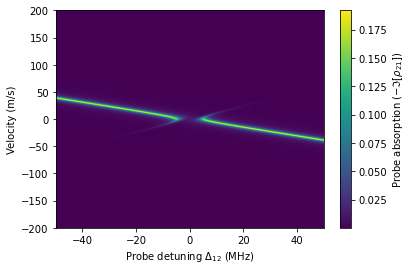

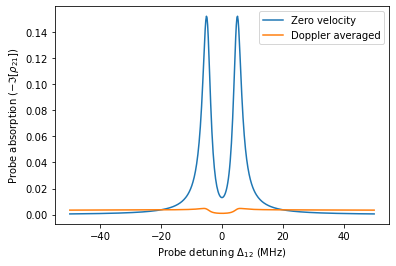

In [11]:
Omegas = [1,10] # 2pi MHz
Deltas = [0,0] # 2pi MHz
Gammas = [5,1] # 2pi MHz
gammas = [0.1,0.1] # 2pi MHz
lamdas = numpy.asarray([780, 480])*1e-9 #m
# Set the beams to be propagating in opposite directions
directions = numpy.asarray([1,-1]) #unitless direction vectors. 
ks = directions/lamdas # 2pi m^-1 # Calculate wavevector

Delta_12 = numpy.linspace(-50,50,500)  #2pi MHz
velocities = numpy.linspace(-200, 200, 501) #m/s
probe_abs = numpy.zeros((len(velocities), len(Delta_12)))

for i, v in enumerate(velocities):
    for j, p in enumerate(Delta_12):
        Deltas[0] = p
        # For each value of velocity, calculate the effective detuning
        Deltas_eff = numpy.zeros(len(Deltas))
        for k in range(len(Deltas)):
            Deltas_eff[k] = Deltas[k]+(ks[k]*v)*1e-6 # to convert to MHz
        solution = OBE.fast_3_level(Omegas, Deltas_eff, Gammas, gammas = gammas)
        probe_abs[i,j] = -numpy.imag(solution)
         
int_manual = numpy.zeros(len(Delta_12))
pdf = OBE.MBdist(velocities)
vel_step = velocities[-1] - velocities[-2]

# Perform the integration 'manually' i.e. using the rectangle rule.
for i in range(len(Delta_12)):
    p_slice = probe_abs[:,i]
    weighted = p_slice*pdf*vel_step
    int_manual[i] = numpy.sum(weighted)

# Plot a colourmap of the probe coherence over both detuning and velocity
pyplot.figure()
pyplot.imshow(probe_abs, aspect = 'auto', origin = 'lower',
              extent = [Delta_12[0], Delta_12[-1], velocities[0], velocities[-1]])
pyplot.colorbar(label = r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.xlabel(r'Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Velocity (m/s)')
pyplot.show()

# Plot the shape of the probe absorption signal 
# for the thermal case and the zero-velocity case
pyplot.figure()
pyplot.plot(Delta_12, probe_abs[len(velocities)//2,:], label = 'Zero velocity')
pyplot.plot(Delta_12, int_manual, label = 'Doppler averaged')
pyplot.xlabel(r'Probe detuning $\Delta_{12}$ (MHz)')
pyplot.ylabel(r'Probe absorption ($-\Im[\rho_{21}]$)')
pyplot.legend(loc=0)
pyplot.show()

## Time-dependent Solutions

### Example 11: Time evolution of the state vector

First let us consider the state vector for a two-level system $|\psi(t)\rangle = c_1(t)|1\rangle + c_2(t)|2\rangle$ which can be written as
$$|\psi(t)\rangle = \begin{pmatrix} c_1(t) \\ c_2(t) \end{pmatrix}.$$

The time evolution of the state vector is of course governed by the Schrödinger equation
$$i\hbar\frac{\partial |\psi\rangle}{\partial t} = \hat{H}|\psi\rangle.$$

The state at a time $t$ is then given by
$$|\psi(t)\rangle = \exp\left(-i\hat{H}t\right) |\psi(0)\rangle$$
where $\hat{H}$ is the time-independent Hamiltonian describing the evolution of the state vector, and $|\psi(0)\rangle$ is the state vector at time $t=0$. (We have set $\hbar=1$ for simplicity).

We can use the `Hamiltonian` function from the `OBE_Tools` module to construct the Hamiltonian for our 2-level system by supplying lists of the Rabi frequencies and detunings.

In this example, let us assume that at $t=0$ all population is in the ground state, so 
$$|\psi(0)\rangle = \begin{pmatrix} 1 \\ 0 \end{pmatrix}.$$

We can now see how the populations of each state $|c_{1,2}|^2$ vary over time. Note that we ensure the populations are normalised such that their sum is 1.

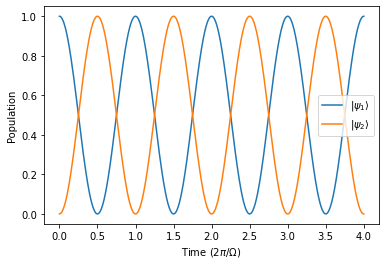

In [12]:
times = numpy.linspace(0,8*numpy.pi,500)
Omegas = [1]
Deltas = [0]
H =  OBE.Hamiltonian(Omegas, Deltas) #Create Hamiltonian
psi_0 = numpy.transpose(numpy.asarray([1,0])) #state vector at t=0
pops = numpy.zeros((len(times),2)) #empty array to store populations

for i, t in enumerate(times):
    sol = OBE.time_evolve(-1j*H, t, psi_0) # perform the time evolution, remembering to add the -i coefficient
    c_1, c_2 = sol[0], sol[1] #extract the coefficients from the solution array
    factor = numpy.absolute(c_1)**2 + numpy.absolute(c_2)**2
    popn = [numpy.absolute(c_1)**2, numpy.absolute(c_2)**2]
    pops[i,:] = popn/factor # store normalised populations in array
    
pyplot.figure()
pyplot.plot(times/(2*numpy.pi), pops[:,0], label = r'$|\psi_1\rangle$')
pyplot.plot(times/(2*numpy.pi), pops[:,1], label = r'$|\psi_2\rangle$')
pyplot.legend()
pyplot.xlabel('Time ($2\pi/\Omega$)')
pyplot.ylabel('Population')
pyplot.show()

As can be seen from the figure, the populations oscillate sinusoidally with a period $\Omega$. This is known as Rabi flopping.

### Example 12: Time evolution of the density matrix (2-level system)

Considering only the state vector, it is not possible to consider the effects of decay. To do this we need to consider the density matrix $\rho$ and its time evolution. We can write the equation governing the time-evolution of the density matrix as 
$$\frac{\partial \rho_{\rm{vect}}}{\partial t} = \hat{M} \rho_{\rm{vect}}$$
where $\rho_{\rm{vect}}$ is a vector that contains all the elements of the density matrix, and $\hat{M}$ is matrix of time-independent coefficients found from the Master equation.
Then we can find the values of $\rho_{\rm{vect}}$ at any time $t$ through
$$\rho_{\rm{vect}}(t) = \exp\left(\hat{M}t\right)\rho_{\rm{vect}}(0)$$
where $\rho_{\rm{vect}}(0)$ is the value of the density matrix in vector form at $t=0$.

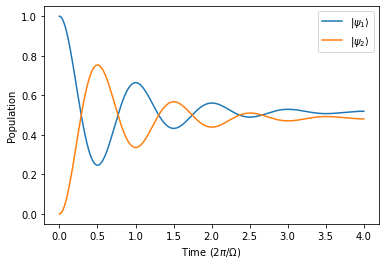

In [13]:
Omegas = [1]
Deltas = [0]
Gammas = [Omegas[0]/4]
M = OBE.time_dep_matrix(Omegas, Deltas, Gammas)

times = numpy.linspace(0,8*numpy.pi,500)
rho_0 = numpy.transpose(numpy.asarray([1,1,1,0]))
rho_t = numpy.zeros((len(times),4))
pops = numpy.zeros((len(times),2))

for i, t in enumerate(times):
    sol = OBE.time_evolve(M, t, rho_0) # perform the time evolution
    rho_11, rho_22 = numpy.real(sol[0]), numpy.real(sol[3]) #extract the populations from the solution array
    factor = rho_11 + rho_22
    popn = [rho_11, rho_22]
    pops[i,:] = popn/factor # store normalised populations in array
    
pyplot.figure()
pyplot.plot(times/(2*numpy.pi), pops[:,0], label = r'$|\psi_1\rangle$')
pyplot.plot(times/(2*numpy.pi), pops[:,1], label = r'$|\psi_2\rangle$')
pyplot.legend()
pyplot.xlabel('Time ($2\pi/\Omega$)')
pyplot.ylabel('Population')
pyplot.show()

### Example 13: Effect of dephasing (2-level system)

Including some additional dephasing ($\gamma = \Omega/10$) gives more strongly damped oscillations.

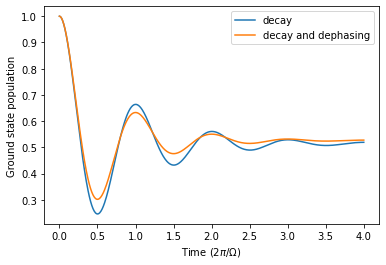

In [14]:
Omegas = [1]
Deltas = [0]
Gammas = [Omegas[0]/4]
M = OBE.time_dep_matrix(Omegas, Deltas, Gammas)
M2 = OBE.time_dep_matrix(Omegas, Deltas, Gammas, gammas = [Omegas[0]/10])

times = numpy.linspace(0,8*numpy.pi,500)
rho_0 = numpy.transpose(numpy.asarray([1,1,1,0]))
rho_t = numpy.zeros((len(times),4))
pops = numpy.zeros((len(times),2))
pops_2 = numpy.zeros((len(times),2))

for i, t in enumerate(times):
    # First, perform time-evolution without dephasing
    sol = OBE.time_evolve(M, t, rho_0) 
    rho_11, rho_22 = numpy.real(sol[0]), numpy.real(sol[3]) 
    factor = rho_11 + rho_22
    popn = [rho_11, rho_22]
    pops[i,:] = popn/factor # store normalised populations in array
    # Then repeat including dephasing
    sol = OBE.time_evolve(M2, t, rho_0) 
    rho_11, rho_22 = numpy.real(sol[0]), numpy.real(sol[3])
    factor = rho_11 + rho_22
    popn = [rho_11, rho_22]
    pops_2[i,:] = popn/factor
    
pyplot.figure()
pyplot.plot(times/(2*numpy.pi), pops[:,0], label = r'decay')
pyplot.plot(times/(2*numpy.pi), pops_2[:,0], label = r'decay and dephasing')
pyplot.legend()
pyplot.xlabel('Time ($2\pi/\Omega$)')
pyplot.ylabel('Ground state population')
pyplot.show()